<a href="https://colab.research.google.com/github/100jy/anomaly/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# module 임포트

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import math

# data


In [3]:
# simulated data
# label이 있는 상황을 가정
ground =  ([[x for x in range(45)]] * 800) 
normal = ground + np.random.rand(800, 45)
anomaly =  ground[:200] + np.random.uniform(0, 2, size=(200, 45))

x_tarin, x_val, _, _ = train_test_split(normal, normal, test_size=0.2)

# 실제 데이터 사용시
# 시간 단위로 분할

## card fraud

In [4]:
# card fraud data
train_df=pd.read_csv('creditcard.csv')

In [120]:
# set split
train_df['Amount'] = (train_df['Amount'] - min(train_df['Amount'])) / (train_df['Amount'].max() - train_df['Amount'].min())

normal = train_df[train_df['Class'] == 0]
sample = np.random.choice(normal.index, 10000)
sam_idx = [x in sample for x in normal.index]
normal = normal[sam_idx]
anomaly = train_df[train_df['Class'] == 1]

cutpoint = int(len(normal)*(8/10))

x_tarin = normal.iloc[:cutpoint,1:-1].values
x_val = normal.iloc[cutpoint:,1:-1].values
anomaly = anomaly.iloc[:,1:-1].values

# OC-SVD

In [ ]:
# grid search by F1
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

score = make_scorer(f1_score, greater_is_better=True)

# SVM 
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
# degree : Degree of the polynomial kernel function
# eta : An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'degree':[2,3,4], 'nu' : [0.01,0.05, 0.1, 0.3, 0.5, 0.7, 0.9]}

oc_svm = OneClassSVM()
clf = GridSearchCV(oc_svm, parameters, scoring=score)

X = np.concatenate([x_val, anomaly])
Y = np.concatenate([np.ones(len(x_val)), np.ones(len(anomaly)) * -1])
clf.fit(X, Y)

In [109]:
print(clf.best_score_)
print(clf.best_params_)

0.7952933641496905
{'degree': 2, 'kernel': 'rbf', 'nu': 0.01}


In [121]:
oc_svm = OneClassSVM(**clf.best_params_)
oc_svm.fit(x_tarin)

OneClassSVM(cache_size=200, coef0=0.0, degree=2, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

## evaluation

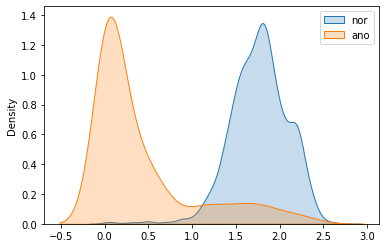

In [122]:
# [0,inf] -> (0,1)
def activation(x):
  return (2/math.pi) * np.arctan(x)

normal_score = (oc_svm.score_samples(x_val))
val_score = (oc_svm.score_samples(anomaly))

plt.figure()
sns.kdeplot(normal_score, fill=True)
sns.kdeplot(val_score, fill=True)

plt.legend(['nor','ano'])
plt.show()

In [123]:
precision = sum(oc_svm.predict(anomaly) == -1)/ (sum(oc_svm.predict(anomaly) == -1) + sum(oc_svm.predict(x_val) == -1))
recall = sum(oc_svm.predict(anomaly) == -1)/ len(anomaly)
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F1Score = 2*(recall* precision) / (recall + precision)
print('precision : {:.5f}, recall : {:.5f}'.format(precision, recall))
print('F1 score : {:.5f}'.format(F1Score))

precision : 0.73805, recall : 0.84756
F1 score : 0.78903


# iforest

In [ ]:
# isolation forest
